MARKETING A/B TESTING ANALYSIS:

This project evaluates the effectiveness of a marketing ad campaign using A/B testing methodology. By comparing a test group (users exposed to ads) with a control group (users exposed to Public Service Announcements, PSAs), we assess whether ad exposure leads to a statistically significant improvement in user conversions

WORKFLOW:
1. Data Preparation
- Imported and inspected the dataset for structure, missing values and duplicate values.
- Applied outlier detection on the Total Ads and Most Ads Hour columns using the Interquartile Range (IQR) method to remove extreme values that could bias results.
2. Exploratory Data Analysis (EDA)
- Visualized conversion across Test (Ad) and Control (PSA) groups.
- Examined the distribution of Total Ads viewed and Most Ads Hours.
- Analyzed conversion patterns and identified peak ad exposure times by day and hour.
3. A/B Testing
- Split the dataset into Group A (Ad) and Group B (PSA).
- Calculated conversion rates for both groups.
- Conducted an Independent T-test to evaluate statistical significance of observed differences.

HYPOTHESIS
- Null Hypothesis (H₀): No difference exists in conversion rates between the Ad group and the PSA group.
- Alternative Hypothesis (H₁): Conversion rates differ between the Ad group and the PSA group (with the expectation that ads increase conversions).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import ttest_ind

In [2]:
df=pd.read_csv("./dataset/marketing_AB.csv")

In [3]:
dataGlimpse = pd.concat([df.head(), df.tail()])
print(dataGlimpse)

        Unnamed: 0  user id test group  converted  total ads most ads day  \
0                0  1069124         ad      False        130       Monday   
1                1  1119715         ad      False         93      Tuesday   
2                2  1144181         ad      False         21      Tuesday   
3                3  1435133         ad      False        355      Tuesday   
4                4  1015700         ad      False        276       Friday   
588096      588096  1278437         ad      False          1      Tuesday   
588097      588097  1327975         ad      False          1      Tuesday   
588098      588098  1038442         ad      False          3      Tuesday   
588099      588099  1496395         ad      False          1      Tuesday   
588100      588100  1237779         ad      False          1      Tuesday   

        most ads hour  
0                  20  
1                  22  
2                  18  
3                  10  
4                  14  
588096  

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [5]:
df.describe()

,Unnamed: 0,user id,total ads,most ads hour
count,588101.000000,5.881010e+05,588101.000000,588101.000000
mean,294050.000000,1.310692e+06,24.820876,14.469061
std,169770.279668,2.022260e+05,43.715181,4.834634
min,0.000000,9.000000e+05,1.000000,0.000000
25%,147025.000000,1.143190e+06,4.000000,11.000000
50%,294050.000000,1.313725e+06,13.000000,14.000000
75%,441075.000000,1.484088e+06,27.000000,18.000000
max,588100.000000,1.654483e+06,2065.000000,23.000000


EDA

In [6]:
df["test group"].unique()

array(['ad', 'psa'], dtype=object)

In [7]:
dataGlimpse

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14
588096,588096,1278437,ad,False,1,Tuesday,23
588097,588097,1327975,ad,False,1,Tuesday,23
588098,588098,1038442,ad,False,3,Tuesday,23
588099,588099,1496395,ad,False,1,Tuesday,23
588100,588100,1237779,ad,False,1,Tuesday,23


In [32]:
# check for missing values

na = df.isnull().sum().sum()
print(na)

if na:
    print(f"{na} missing values found in data")
else:
    print("No missing values found in data")

0
No missing values found in data


In [9]:
# Check for duplicate user ids

dup_mask = df['user id'].duplicated(keep=False)
n_dup_total = int(dup_mask.sum())
n_dup_unique = int(df.loc[dup_mask, 'user id'].nunique())

print(f"Total rows with duplicated user id: {n_dup_total}")
print(f"Number of unique user ids duplicated: {n_dup_unique}")

if n_dup_total:
    dup_counts = df.loc[dup_mask, 'user id'].value_counts()
    print("\nTop duplicated user ids (id: count):")
    print(dup_counts.head(10))
    print("\nExample duplicated rows:")
    print(df.loc[dup_mask].sort_values('user id').head(20))
else:
    print("No duplicate user ids found.")

Total rows with duplicated user id: 0
Number of unique user ids duplicated: 0
No duplicate user ids found.


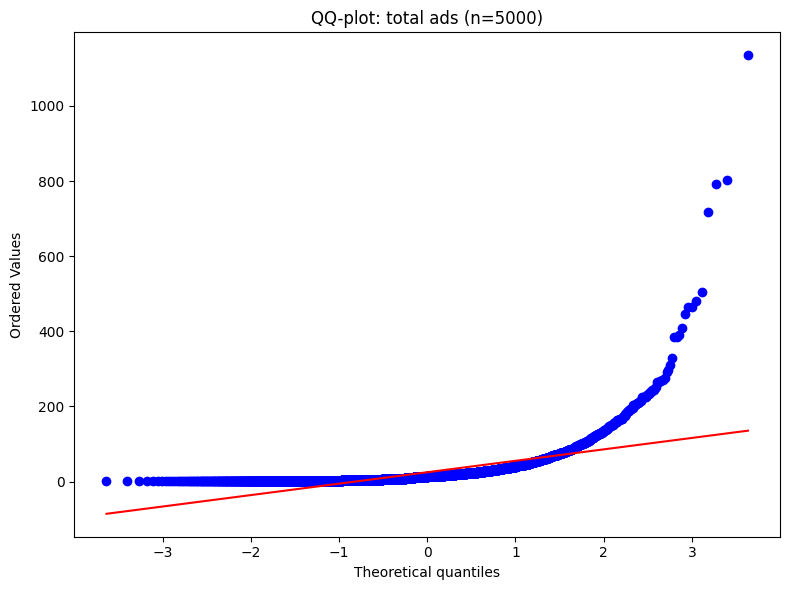

Shapiro-Wilk test (n=5000): W=0.45834, p-value=6.876e-82
Reject normality at alpha=0.05


In [10]:
# Test normality of 'total ads'

from scipy.stats import shapiro, probplot

s = df['total ads']

# use existing series `s` (total ads). Shapiro-Wilk is expensive for large n -> sample up to 5000
n = len(s)
sample_n = min(5000, n)
sample = s.sample(sample_n, random_state=42) if n > sample_n else s

# QQ-plot
plt.figure(figsize=(8, 6))
probplot(sample, dist="norm", plot=plt)
ax = plt.gca()
ax.set_title(f"QQ-plot: total ads (n={sample_n})")
plt.tight_layout()
plt.show()

# Shapiro-Wilk test
stat, p = shapiro(sample)
print(f"Shapiro-Wilk test (n={sample_n}): W={stat:.5f}, p-value={p:.5g}")
if p < 0.05:
    print("Reject normality at alpha=0.05")
else:
    print("Fail to reject normality at alpha=0.05")

Since data is not normal so we will proceed with IQR method instead of Z-score to detect outliers in 'total ads'

Q1=4.0, Q3=27.0, IQR=23.0
Lower bound=-30.5, Upper bound=61.5
Outliers detected: 52057 rows (8.8517%)


,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14
5,5,1137664,ad,False,734,Saturday,10
6,6,1116205,ad,False,264,Wednesday,13
9,9,1446284,ad,False,142,Monday,14
10,10,1257223,ad,False,209,Wednesday,11
16,16,1492276,ad,False,64,Tuesday,12
18,18,900681,psa,False,248,Saturday,19


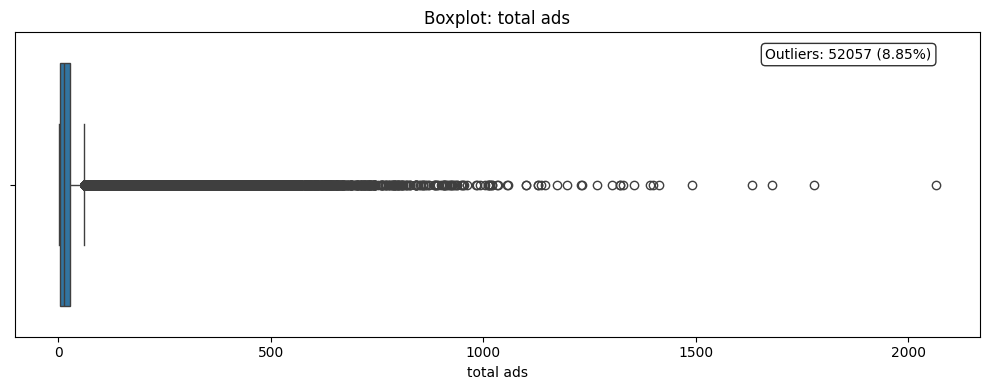

In [11]:
# IQR outlier detection for 'total ads', boxplot and list of outliers
q1 = s.quantile(0.25)
q3 = s.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

iqr_mask = (s < lower) | (s > upper)
n_outliers = int(iqr_mask.sum())
pct_outliers = n_outliers / len(df)

print(f"Q1={q1}, Q3={q3}, IQR={iqr}")
print(f"Lower bound={lower}, Upper bound={upper}")
print(f"Outliers detected: {n_outliers} rows ({pct_outliers:.4%})")

# create dataframe of outlier rows and a list of outlier values
total_ads_outlier_rows = df.loc[iqr_mask].copy()
total_ads_outlier_values = total_ads_outlier_rows['total ads'].tolist()

# show a small sample of the outliers (first 10)
display(total_ads_outlier_rows.head(10))

# boxplot to visualize outliers
plt.figure(figsize=(10, 4))
ax_total_box = sns.boxplot(x=df['total ads'], color='C0')
ax_total_box.set_title("Boxplot: total ads")
ax_total_box.set_xlabel("total ads")

# annotate number of outliers on the plot
ax_total_box.text(0.95, 0.95, f"Outliers: {n_outliers} ({pct_outliers:.2%})",
                  transform=ax_total_box.transAxes, ha='right', va='top',
                  bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

In [12]:
print(lower, upper)
print(sorted(total_ads_outlier_values, reverse=False))
print(len(total_ads_outlier_values))
print(len(s)-len(total_ads_outlier_values))

-30.5 61.5
[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 

In [13]:
print("Total ads outliers count w.r.t. test group: \n",total_ads_outlier_rows.groupby('test group')['total ads'].count())
print("\nTotal ads outliers count that belongs to psa group w.r.t conversion: \n",total_ads_outlier_rows[df['test group']=='psa'].groupby('converted')['total ads'].count())
print("\nTotal ads outliers count that belongs to ad group w.r.t conversion: \n",total_ads_outlier_rows[df['test group']=='ad'].groupby('converted')['total ads'].count())

Total ads outliers count w.r.t. test group: 
 test group
ad     49861
psa     2196
Name: total ads, dtype: int64

Total ads outliers count that belongs to psa group w.r.t conversion: 
 converted
False    2002
True      194
Name: total ads, dtype: int64

Total ads outliers count that belongs to ad group w.r.t conversion: 
 converted
False    42327
True      7534
Name: total ads, dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_32320\3859758593.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("\nTotal ads outliers count that belongs to psa group w.r.t conversion: \n",total_ads_outlier_rows[df['test group']=='psa'].groupby('converted')['total ads'].count())
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_32320\3859758593.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("\nTotal ads outliers count that belongs to ad group w.r.t conversion: \n",total_ads_outlier_rows[df['test group']=='ad'].groupby('converted')['total ads'].count())


In [14]:
# Dataset after removing total ads outliers

df_clean=df[~iqr_mask]
df_clean

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
2,2,1144181,ad,False,21,Tuesday,18
7,7,1496843,ad,False,17,Sunday,18
8,8,1448851,ad,False,21,Tuesday,19
11,11,1637531,ad,False,47,Wednesday,13
12,12,1081965,ad,False,61,Tuesday,20
...,...,...,...,...,...,...,...
588096,588096,1278437,ad,False,1,Tuesday,23
588097,588097,1327975,ad,False,1,Tuesday,23
588098,588098,1038442,ad,False,3,Tuesday,23
588099,588099,1496395,ad,False,1,Tuesday,23


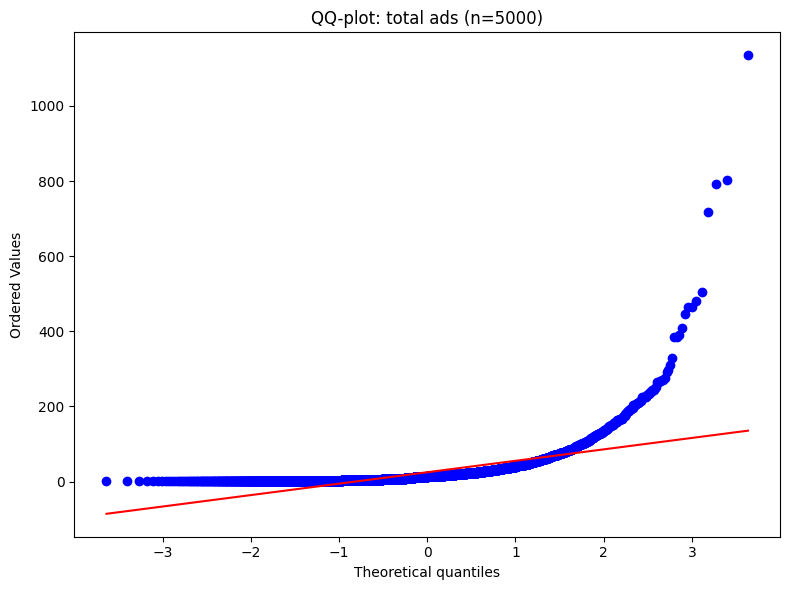

Shapiro-Wilk test (n=5000): W=0.45834, p-value=6.876e-82
Reject normality at alpha=0.05


In [15]:
# Test normality of 'most ads hour'

s1 = df_clean['most ads hour']
# use existing series `s1` (most ads hour). Shapiro-Wilk is expensive for large n -> sample up to 5000
n1 = len(s1)
sample_n1 = min(5000, n1)
sample1 = s.sample(sample_n1, random_state=42) if n > sample_n1 else s

# QQ-plot
plt.figure(figsize=(8, 6))
probplot(sample1, dist="norm", plot=plt)
ax = plt.gca()
ax.set_title(f"QQ-plot: total ads (n={sample_n1})")
plt.tight_layout()
plt.show()

# Shapiro-Wilk test
stat, p = shapiro(sample1)
print(f"Shapiro-Wilk test (n={sample_n1}): W={stat:.5f}, p-value={p:.5g}")
if p < 0.05:
    print("Reject normality at alpha=0.05")
else:
    print("Fail to reject normality at alpha=0.05")

Since data is not normal so we will proceed with IQR method instead of Z-score to detect outliers in 'most ads hour'

Q1=11.0, Q3=18.0, IQR=7.0
Lower bound=0.5, Upper bound=28.5
Outliers detected: 5078 rows (0.9473%)


,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
205,205,909288,psa,False,22,Friday,0
407,407,1443603,ad,False,43,Saturday,0
432,432,1003028,ad,False,22,Wednesday,0
694,694,1003096,ad,False,25,Thursday,0
746,746,1176995,ad,False,39,Thursday,0
999,999,1507989,ad,False,8,Friday,0
1006,1006,1133374,ad,False,59,Wednesday,0
1007,1007,1102609,ad,False,3,Wednesday,0
1059,1059,1222289,ad,False,60,Wednesday,0
1141,1141,1527077,ad,False,31,Sunday,0


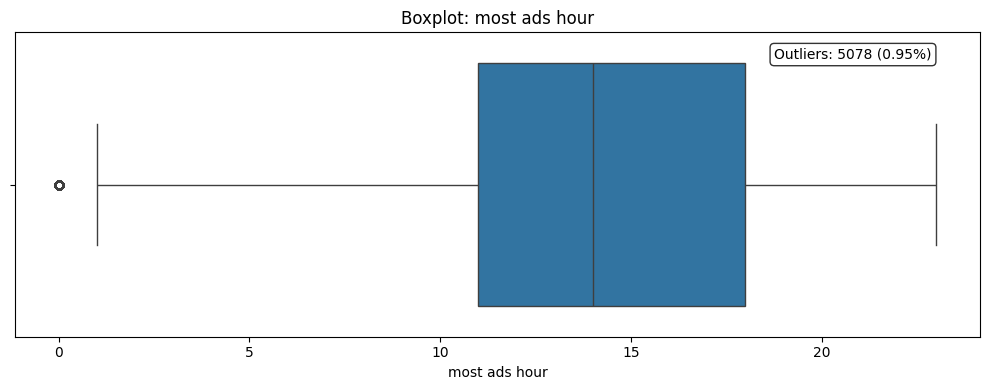

In [16]:
# IQR outlier detection for 'most ads hour', boxplot and list of outliers
q1_hour = s1.quantile(0.25)
q3_hour = s1.quantile(0.75)
iqr_hour = q3_hour - q1_hour
lower_hour = q1_hour - 1.5 * iqr_hour
upper_hour = q3_hour + 1.5 * iqr_hour

iqr_mask_hour = (s1 < lower_hour) | (s1 > upper_hour)
n_outliers_hour = int(iqr_mask_hour.sum())
pct_outliers_hour = n_outliers_hour / len(df_clean)

print(f"Q1={q1_hour}, Q3={q3_hour}, IQR={iqr_hour}")
print(f"Lower bound={lower_hour}, Upper bound={upper_hour}")
print(f"Outliers detected: {n_outliers_hour} rows ({pct_outliers_hour:.4%})")

# create dataframe of outlier rows and a list of outlier values
total_ads_outlier_rows_hour = df_clean.loc[iqr_mask_hour].copy()
total_ads_outlier_values_hour = total_ads_outlier_rows_hour['most ads hour'].tolist()

# show a small sample of the outliers (first 10)
display(total_ads_outlier_rows_hour.head(10))

# boxplot to visualize outliers
plt.figure(figsize=(10, 4))
ax_total_box_hour = sns.boxplot(x=df_clean['most ads hour'], color='C0')
ax_total_box_hour.set_title("Boxplot: most ads hour")
ax_total_box_hour.set_xlabel("most ads hour")

# annotate number of outliers on the plot
ax_total_box_hour.text(0.95, 0.95, f"Outliers: {n_outliers_hour} ({pct_outliers_hour:.2%})",
                  transform=ax_total_box_hour.transAxes, ha='right', va='top',
                  bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

In [17]:
print(lower_hour, upper_hour)
print(sorted(total_ads_outlier_values_hour, reverse=False))
print(len(total_ads_outlier_values_hour))
print(len(s1)-len(total_ads_outlier_values_hour))

0.5 28.5
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [18]:
print("Most ads hour outliers count w.r.t. test group: \n",total_ads_outlier_rows_hour.groupby('test group')['most ads hour'].count())
print("\nMost ads hour outliers count that belongs to psa group w.r.t conversion: \n",total_ads_outlier_rows_hour[df['test group']=='psa'].groupby('converted')['most ads hour'].count())
print("\nMost ads hour outliers count that belongs to ad group w.r.t conversion: \n",total_ads_outlier_rows_hour[df['test group']=='ad'].groupby('converted')['most ads hour'].count())

Most ads hour outliers count w.r.t. test group: 
 test group
ad     4869
psa     209
Name: most ads hour, dtype: int64

Most ads hour outliers count that belongs to psa group w.r.t conversion: 
 converted
False    209
Name: most ads hour, dtype: int64

Most ads hour outliers count that belongs to ad group w.r.t conversion: 
 converted
False    4812
True       57
Name: most ads hour, dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_32320\1580681126.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("\nMost ads hour outliers count that belongs to psa group w.r.t conversion: \n",total_ads_outlier_rows_hour[df['test group']=='psa'].groupby('converted')['most ads hour'].count())
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_32320\1580681126.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("\nMost ads hour outliers count that belongs to ad group w.r.t conversion: \n",total_ads_outlier_rows_hour[df['test group']=='ad'].groupby('converted')['most ads hour'].count())


In [19]:
# Dataset after removing most ads hour outliers

df_final=df_clean[~iqr_mask_hour]
df_final

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
2,2,1144181,ad,False,21,Tuesday,18
7,7,1496843,ad,False,17,Sunday,18
8,8,1448851,ad,False,21,Tuesday,19
11,11,1637531,ad,False,47,Wednesday,13
12,12,1081965,ad,False,61,Tuesday,20
...,...,...,...,...,...,...,...
588096,588096,1278437,ad,False,1,Tuesday,23
588097,588097,1327975,ad,False,1,Tuesday,23
588098,588098,1038442,ad,False,3,Tuesday,23
588099,588099,1496395,ad,False,1,Tuesday,23


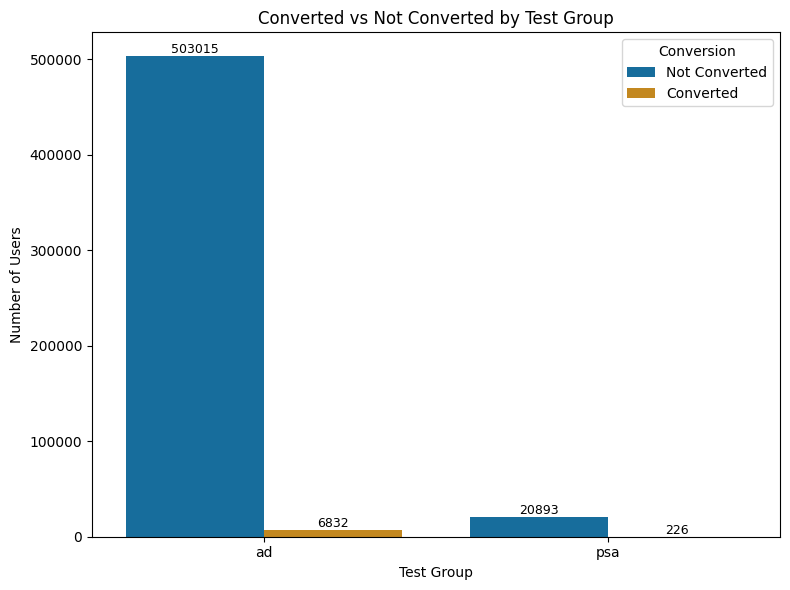

In [20]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df_final, x='test group', hue='converted',
                   palette=sns.color_palette("colorblind", 2))

ax.set_xlabel("Test Group")
ax.set_ylabel("Number of Users")
ax.set_title("Converted vs Not Converted by Test Group")

# Rename legend entries from True/False to readable labels
handles, labels = ax.get_legend_handles_labels()
label_map = {'True': 'Converted', 'False': 'Not Converted'}
ax.legend(handles, [label_map.get(l, l) for l in labels], title='Conversion')

# Annotate bars with counts
for p in ax.patches:
    height = int(p.get_height())
    if height:
        ax.annotate(height,
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

note that there is a class imbalance in the dataset but we don't really have to tackle that problem because our metric would be 'conversion rate' which is robust to class size of control group

In [21]:
print(df_final[df_final['test group']=='ad'].groupby('converted')['total ads'].mean())
print(df_final[df_final['test group']=='psa'].groupby('converted')['total ads'].mean())

converted
False    14.924050
True     33.262002
Name: total ads, dtype: float64
converted
False    14.347628
True     28.654867
Name: total ads, dtype: float64


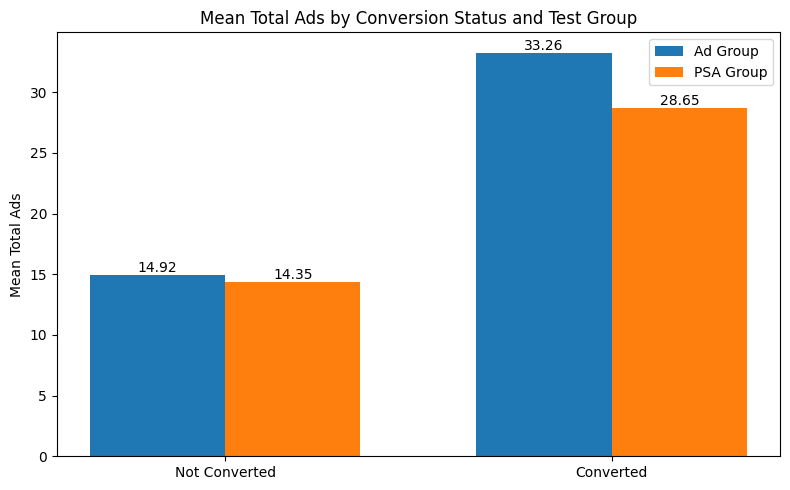

In [22]:
# Visualize mean total ads by conversion status for each test group

fig, ax = plt.subplots(figsize=(8, 5))
means_ad = df_final[df_final['test group']=='ad'].groupby('converted')['total ads'].mean()
means_psa = df_final[df_final['test group']=='psa'].groupby('converted')['total ads'].mean()

x = np.arange(2)
width = 0.35

ax.bar(x - width/2, means_ad.values, width, label='Ad Group')
ax.bar(x + width/2, means_psa.values, width, label='PSA Group')

ax.set_xticks(x)
ax.set_xticklabels(['Not Converted', 'Converted'])
ax.set_ylabel('Mean Total Ads')
ax.set_title('Mean Total Ads by Conversion Status and Test Group')
ax.legend()

for i in range(2):
    ax.text(x[i] - width/2, means_ad.values[i], f"{means_ad.values[i]:.2f}", ha='center', va='bottom')
    ax.text(x[i] + width/2, means_psa.values[i], f"{means_psa.values[i]:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

from above graph we can interpret that on an average for conversion around 33 ads are required for 'ad' group whereas only 28 (approx) ads are required for 'psa' test group

In [23]:
df_final.groupby('most ads day')['converted'].count()

most ads day
Friday       82874
Monday       78268
Saturday     73734
Sunday       77147
Thursday     75651
Tuesday      70193
Wednesday    73099
Name: converted, dtype: int64

In [24]:
df_final.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
2,2,1144181,ad,False,21,Tuesday,18
7,7,1496843,ad,False,17,Sunday,18
8,8,1448851,ad,False,21,Tuesday,19
11,11,1637531,ad,False,47,Wednesday,13
12,12,1081965,ad,False,61,Tuesday,20


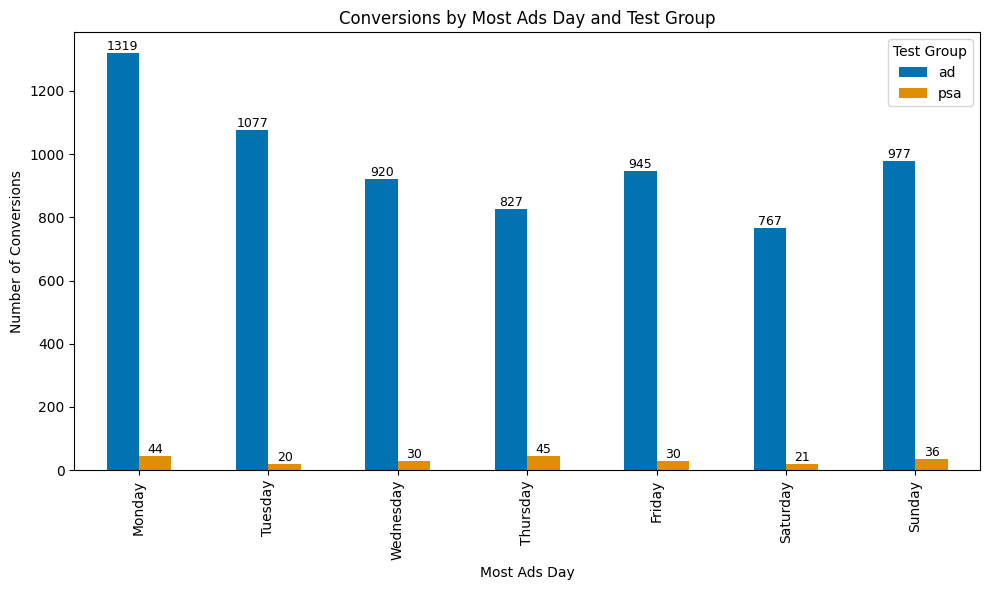

In [25]:
# Plot conversions by most ads day, bifurcated by test group
conv = df_final[df_final['converted'] == True]
counts = conv.groupby(['most ads day', 'test group']).size().unstack(fill_value=0)

# enforce weekday order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
counts = counts.reindex(day_order).fillna(0)

ax_conv = counts.plot(kind='bar', figsize=(10, 6), color=sns.color_palette("colorblind", 2))
ax_conv.set_xlabel("Most Ads Day")
ax_conv.set_ylabel("Number of Conversions")
ax_conv.set_title("Conversions by Most Ads Day and Test Group")
ax_conv.legend(title="Test Group")

# annotate bars with counts
for p in ax_conv.patches:
    h = p.get_height()
    if h:
        ax_conv.annotate(f"{int(h)}", (p.get_x() + p.get_width() / 2, h),
                         ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In above graphs we can clearly see the huge difference in conversion for both test group but due to class imbalance it's not advisable to conclude any final statement rightnow

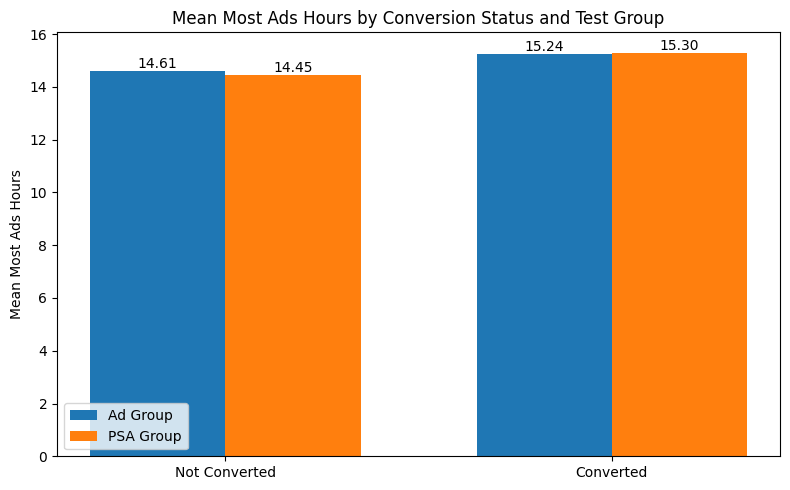

In [26]:
# Visualize mean most ads hour by conversion status for each test group

fig, ax = plt.subplots(figsize=(8, 5))
means_ad = df_final[df_final['test group']=='ad'].groupby('converted')['most ads hour'].mean()
means_psa = df_final[df_final['test group']=='psa'].groupby('converted')['most ads hour'].mean()

x = np.arange(2)
width = 0.35

ax.bar(x - width/2, means_ad.values, width, label='Ad Group')
ax.bar(x + width/2, means_psa.values, width, label='PSA Group')

ax.set_xticks(x)
ax.set_xticklabels(['Not Converted', 'Converted'])
ax.set_ylabel('Mean Most Ads Hours')
ax.set_title('Mean Most Ads Hours by Conversion Status and Test Group')
ax.legend()

for i in range(2):
    ax.text(x[i] - width/2, means_ad.values[i], f"{means_ad.values[i]:.2f}", ha='center', va='bottom')
    ax.text(x[i] + width/2, means_psa.values[i], f"{means_psa.values[i]:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

from above graph we can interpret that most ads hour doesn't have significant difference between conversion of 'ad' group and 'psa' group

A/B TESTING:

In [28]:
# A/B test (two-sample t-test) on conversion rate between 'ad' and 'psa' groups
# Null hypothesis: no difference in conversion rate between groups

ad = df_final[df_final['test group'] == 'ad']['converted'].astype(int)
psa = df_final[df_final['test group'] == 'psa']['converted'].astype(int)

n_ad, n_psa = len(ad), len(psa)
cr_ad, cr_psa = ad.mean(), psa.mean()
diff = cr_ad - cr_psa

# Welch's t-test (unequal variances)
t_stat, p_value = ttest_ind(ad, psa, equal_var=False)

# 95% CI for difference in proportions using normal approximation (large samples)
se = np.sqrt(cr_ad * (1 - cr_ad) / n_ad + cr_psa * (1 - cr_psa) / n_psa)
z95 = 1.96
ci_lower, ci_upper = diff - z95 * se, diff + z95 * se

print("Group sizes: ad =", n_ad, ", psa =", n_psa)
print(f"Conversion rates: ad = {cr_ad:.4%}, psa = {cr_psa:.4%}")
print(f"Difference (ad - psa) = {diff:.4%}")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.5g}")
print(f"95% CI for difference = ({ci_lower:.4%}, {ci_upper:.4%})")

alpha = 0.05
if p_value < alpha:
    print(f"Reject H0 at alpha={alpha}: conversion rates differ between groups.")
else:
    print(f"Fail to reject H0 at alpha={alpha}: no evidence of difference in conversion rates.")

Group sizes: ad = 509847 , psa = 21119
Conversion rates: ad = 1.3400%, psa = 1.0701%
Difference (ad - psa) = 0.2699%
t-statistic = 3.7168, p-value = 0.00020223
95% CI for difference = (0.1276%, 0.4122%)
Reject H0 at alpha=0.05: conversion rates differ between groups.


In [29]:
# Final conclusion summary (can be run in the current notebook cell)
conclusion = f"""
Final conclusion:
- Observed conversion rates: Ad = {cr_ad:.4%}, PSA = {cr_psa:.4%}
    Absolute difference in conversion rates (Ad - PSA) = {diff:.4%} (≈{(diff/cr_psa):.1%} relative lift).
- Statistical test (Welch two-sample t-test): t = {t_stat:.4f}, p = {p_value:.5g}, alpha = {alpha}
    95% CI for difference = ({ci_lower:.4%}, {ci_upper:.4%}).

Interpretation:
- The p-value < alpha so we reject the null hypothesis of no difference.
- The 95% CI is entirely positive, so the 'ad' variant shows a statistically significant higher conversion rate than 'psa'.
- Effect size: the absolute uplift is ~{diff:.4%} (small in absolute terms), but relative uplift is ~{(diff/cr_psa):.1%}.

Business recommendation (preferred strategy):
- Prefer the 'ad' variant for rollout, subject to business validation:
    - Expected incremental conversions ≈ {int(diff * 100000)} per 100k users exposed.
    - Before full rollout, perform an ROI analysis: compare incremental revenue per conversion vs incremental cost of serving 'ad'.
    - Run a staged rollout (canary/holdout) while monitoring secondary metrics (retention, engagement, conversion quality, churn).

Next steps & caveats:
- Although results are statistically significant (large sample), evaluate practical significance and unit economics.
- Conduct segment analysis to identify cohorts with larger lifts (targeted rollout).
- Confirm results with a proportion z-test or Bayesian analysis and ensure no bias from preprocessing/outlier handling.
- Monitor metrics post-rollout to catch unintended effects.

"""
print(conclusion)


Final conclusion:
- Observed conversion rates: Ad = 1.3400%, PSA = 1.0701%
    Absolute difference in conversion rates (Ad - PSA) = 0.2699% (≈25.2% relative lift).
- Statistical test (Welch two-sample t-test): t = 3.7168, p = 0.00020223, alpha = 0.05
    95% CI for difference = (0.1276%, 0.4122%).

Interpretation:
- The p-value < alpha so we reject the null hypothesis of no difference.
- The 95% CI is entirely positive, so the 'ad' variant shows a statistically significant higher conversion rate than 'psa'.
- Effect size: the absolute uplift is ~0.2699% (small in absolute terms), but relative uplift is ~25.2%.

Business recommendation (preferred strategy):
- Prefer the 'ad' variant for rollout, subject to business validation:
    - Expected incremental conversions ≈ 269 per 100k users exposed.
    - Before full rollout, perform an ROI analysis: compare incremental revenue per conversion vs incremental cost of serving 'ad'.
    - Run a staged rollout (canary/holdout) while monitoring s